In [1]:
import sys, os, glob
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
oceandirect_path = 'C:/Program Files/Ocean Optics/OceanDirect SDK/Python/'
sys.path.append(os.path.abspath(oceandirect_path))
from Read_Spectrum import *
import pandas as pd
import matplotlib.cm as cm
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

In [2]:
os.getcwd()

'c:\\Users\\Willi\\Documents\\GitHub\\HIRAX\\Ocean_Insight'

In [ ]:
read_all_serial_numbers()
odapi.find_usb_devices()
devId = odapi.get_device_ids()[0]
device = odapi.open_device(devId)
devSerialNumber = device.get_serial_number()

In [16]:
read_spectra(read_all_serial_numbers()[0], 30000, 1, './Spectral_Files/Testing.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([-111.51197099, -111.51197099, -111.51197099, ...,  174.31195814,
          176.3122669 ,  182.3133071 ])])

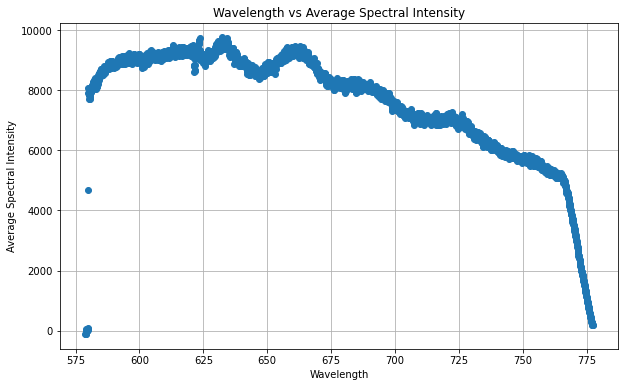

In [18]:
# df = pd.read_csv('./Spectral_Files/Filter_Throughput_31C.csv')
df = pd.read_csv('./Spectral_Files/Testing.csv')

# Step 2: Calculate the average spectral intensity
# Assuming the first column is 'Wavelength' and the next five columns are spectral data
average_spectral_intensity = df.iloc[:, 1:].mean(axis=1)

# Step 3: Combine the wavelengths with their corresponding average spectral intensity
result = pd.DataFrame({
    'Wavelength': df.iloc[:, 0],
    'Average_Spectral_Intensity': average_spectral_intensity
})

# Step 4: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(result['Wavelength'], result['Average_Spectral_Intensity'], marker='o', linestyle=' ')
plt.title('Wavelength vs Average Spectral Intensity')
plt.xlabel('Wavelength')
plt.ylabel('Average Spectral Intensity')
plt.grid(True)
plt.show()

In [61]:
data = np.loadtxt('./Spectral_Files/Testing.csv', delimiter=',', skiprows=1)
x_wavelength = data[:,0]
y = data[:,1]

In [63]:
left_closest_value = min(x_wavelength, key=lambda x: abs(x - 590))
right_closest_value = min(x_wavelength, key=lambda x: abs(x - 600))

# Get the index of the closest values using numpy.where
left_index = np.where(x_wavelength == left_closest_value)[0][0]
right_index = np.where(x_wavelength == right_closest_value)[0][0]

print(left_index, right_index)

185 354


In [88]:
# Spectral resolution
resolution = (max(x_wavelength)-min(x_wavelength))/len(x_wavelength)
print("Spectral resolution =", resolution, "nm per pixel")

Spectral resolution = 0.054382097557763256 nm per pixel


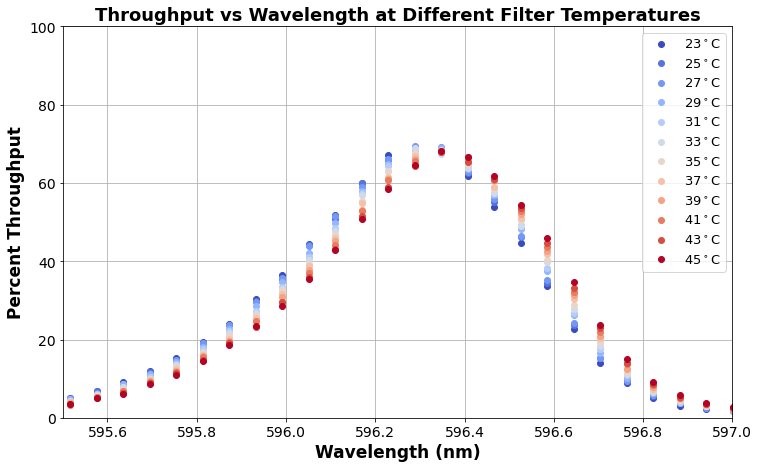

In [117]:
# Temperature refers to the sensor on the outer lens tube rim. Median intensity over 5 images with 30000 us integration time

# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')

# Load throughput files
throughput_23_29 = pd.read_csv('./Spectral_Files/Base_Throughput_350.csv')
throughput_31_45 = pd.read_csv('./Spectral_Files/Base_Throughput.csv')

# Step 2: Initialize a plot
# plt.figure(figsize=(10, 6))
plt.figure(figsize=(12, 7.2))


# Step 3: Extract temperatures and normalize them
temperatures = []
for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

# Normalize temperatures to the range [0, 1]
norm = plt.Normalize(min(temperatures), max(temperatures))
cmap = cm.coolwarm

# Step 4: Iterate through the CSV files and plot
for file in csv_files:
    if file.endswith('C.csv'):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Extract the temperature from the file name
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        
        # Select the appropriate throughput file based on temperature range
        if 23 <= temperature <= 29:
            throughput = throughput_23_29
        elif 31 <= temperature <= 45:
            throughput = throughput_31_45
        else:
            continue  # Skip temperatures outside the specified ranges
        
        # Normalize the intensity values
        normalized_intensity = df.iloc[:, 1:].div(throughput.iloc[:, 1:], axis=0).median(axis=1)
        
        # Combine the wavelengths with their corresponding normalized spectral intensity
        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Normalized_Spectral_Intensity': normalized_intensity
        })
        
        # Get the color from the colormap
        color = cmap(norm(temperature))
        
        # Plot the data
        plt.plot(result['Wavelength'], result['Normalized_Spectral_Intensity']*100, marker='o', linestyle=' ', label=f'{temperature}$^\circ$C', color=color)

# Step 5: Customize the plot
plt.xlim(595.5, 597)
plt.ylim(0, 100)
plt.title('Throughput vs Wavelength at Different Filter Temperatures', fontweight='bold', fontsize=18)
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=17)
plt.ylabel('Percent Throughput', fontweight='bold', fontsize=17)
plt.legend(fontsize=13)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=14)

# Step 6: Show the plot
plt.show()

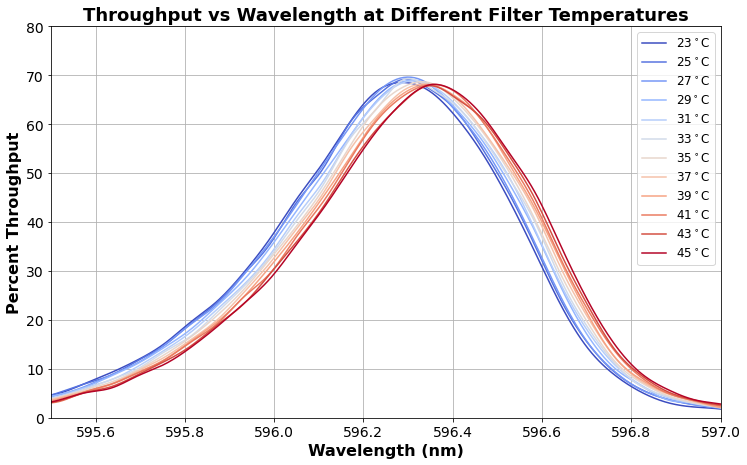

In [116]:
# Interpolated data (smooth)

# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')

# Load throughput files
throughput_23_29 = pd.read_csv('./Spectral_Files/Base_Throughput_345.csv')
throughput_31_45 = pd.read_csv('./Spectral_Files/Base_Throughput.csv')

# Step 2: Initialize a plot
plt.figure(figsize=(12, 7.2))

# Step 3: Extract temperatures and normalize them
temperatures = []
for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

# Normalize temperatures to the range [0, 1]
norm = plt.Normalize(min(temperatures), max(temperatures))
cmap = cm.coolwarm

# Step 4: Iterate through the CSV files and plot
for file in csv_files:
    if file.endswith('C.csv'):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Extract the temperature from the file name
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        
        # Select the appropriate throughput file based on temperature range
        if 23 <= temperature <= 29:
            throughput = throughput_23_29
        elif 31 <= temperature <= 45:
            throughput = throughput_31_45
        else:
            continue  # Skip temperatures outside the specified ranges
        
        # Normalize the intensity values
        normalized_intensity = df.iloc[:, 1:].div(throughput.iloc[:, 1:], axis=0).median(axis=1)
        
        # Combine the wavelengths with their corresponding normalized spectral intensity
        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Normalized_Spectral_Intensity': normalized_intensity
        })
        
        # Interpolate the normalized spectral intensity data
        spline = UnivariateSpline(result['Wavelength'], result['Normalized_Spectral_Intensity'], s=0)
        fine_wavelengths = np.linspace(595, 597, 500)  # Fine grid between 595 and 597 nm
        interpolated_intensity = spline(fine_wavelengths)
        
        # Get the color from the colormap
        color = cmap(norm(temperature))
        
        # Plot the interpolated data
        plt.plot(fine_wavelengths, interpolated_intensity * 100, marker=' ', linestyle='-', label=f'{temperature}$^\circ$C', color=color)

# Step 5: Customize the plot
plt.xlim(595.5, 597)
plt.ylim(0, 80)
plt.title('Throughput vs Wavelength at Different Filter Temperatures', fontweight='bold', fontsize=18)
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=16)
plt.ylabel('Percent Throughput', fontweight='bold', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)

# Change the font size of axis tick mark numbers
plt.tick_params(axis='both', which='major', labelsize=14)

# Step 6: Show the plot
plt.show()

In [97]:
# Now calculate the rate of change in thorughput
# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')

# Step 2: Extract temperatures and initialize lists for peak wavelengths
temperatures = []
peak_wavelengths = []

for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

# Step 3: Iterate through the CSV files and find peak wavelengths
for file in csv_files:
    if file.endswith('C.csv'):
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        
        # Extract the temperature from the file name
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        
        # Calculate the median intensity across all columns (excluding the first column which is wavelength)
        median_intensity = df.iloc[:, 1:].median(axis=1)
        
        # Combine the wavelengths with their corresponding median spectral intensity
        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Median_Spectral_Intensity': median_intensity
        })
        
        # Find the peak wavelength
        peak_wavelength = result.loc[result['Median_Spectral_Intensity'].idxmax(), 'Wavelength']
        peak_wavelengths.append(peak_wavelength)

# Step 4: Calculate the average change in peak wavelength per degree Celsius
temperature_diffs = np.diff(temperatures)
wavelength_diffs = np.diff(peak_wavelengths)
average_change_per_C = np.mean(wavelength_diffs / temperature_diffs)

print(f'Average change in peak wavelength per degree Celsius: {average_change_per_C:.4f} nm/°C')

Average change in peak wavelength per degree Celsius: 0.0027 nm/°C


In [120]:
# Now calculate the rate of change in thorughput
# Step 1: List the CSV files
csv_files = glob.glob('./Spectral_Files/*.csv')

# Step 2: Extract temperatures and initialize lists for peak wavelengths
temperatures = []
peak_wavelengths = []

for file in csv_files:
    if file.endswith('C.csv'):
        temperature_str = file.split('_')[-1].split('.')[0]
        temperature = int(temperature_str.rstrip('C'))
        temperatures.append(temperature)

        df = pd.read_csv(file)

        median_intensity = df.iloc[:, 1:].median(axis=1)

        result = pd.DataFrame({
            'Wavelength': df.iloc[:, 0],
            'Median_Spectral_Intensity': median_intensity
        })
        
        # Interpolate the median spectral intensity data
        spline = UnivariateSpline(result['Wavelength'], result['Median_Spectral_Intensity'], s=0)
        fine_wavelengths = np.linspace(595, 597, 1000)
        interpolated_intensity = spline(fine_wavelengths)
        
        # Find the peak wavelength from the interpolated data
        peak_wavelength = fine_wavelengths[np.argmax(interpolated_intensity)]
        peak_wavelengths.append(peak_wavelength)

print(peak_wavelengths)

# Step 4: Calculate the average change in peak wavelength per degree Celsius
temperature_diffs = np.diff(temperatures)
wavelength_diffs = np.diff(peak_wavelengths)
print(wavelength_diffs)
average_change_per_C = np.mean(wavelength_diffs / temperature_diffs)

print(f'Average change in peak wavelength per degree Celsius: {average_change_per_C:.4f} nm/°C')

[596.2952952952953, 596.3033033033033, 596.3233233233233, 596.3193193193193, 596.3173173173174, 596.3113113113113, 596.3353353353353, 596.3453453453453, 596.3453453453453, 596.3493493493494, 596.3513513513514, 596.3573573573574]
[ 0.00800801  0.02002002 -0.004004   -0.002002   -0.00600601  0.02402402
  0.01001001  0.          0.004004    0.002002    0.00600601]
Average change in peak wavelength per degree Celsius: 0.0028 nm/°C


In [98]:
0.0027e3 # value in picometers
#0.0027 nm/°C

2.7

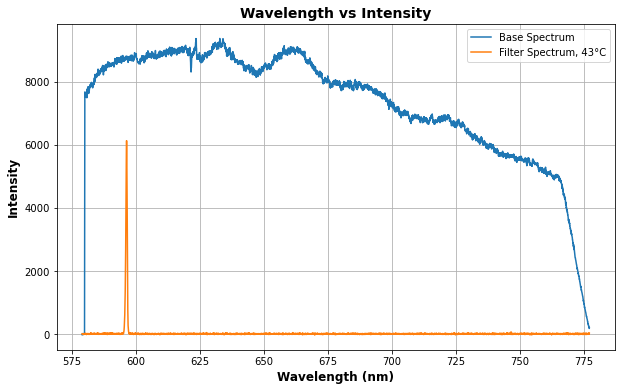

In [48]:
df_base = pd.read_csv('./Spectral_Files/Base_Throughput.csv')
df = pd.read_csv('./Spectral_Files/Filter_Throughput_23C.csv')

# Step 2: Calculate the average spectral intensity
# Assuming the first column is 'Wavelength' and the next five columns are spectral data
median_base_intensity = df_base.iloc[:, 1:].median(axis=1)
median_spectral_intensity = df.iloc[:, 1:].median(axis=1)

# Step 3: Combine the wavelengths with their corresponding average spectral intensity
result_base = pd.DataFrame({
    'Wavelength': df_base.iloc[:, 0],
    'Median_Spectral_Intensity': median_base_intensity
})
result = pd.DataFrame({
    'Wavelength': df.iloc[:, 0],
    'Median_Spectral_Intensity': median_spectral_intensity
})

# Step 4: Plot the data
plt.figure(figsize=(10, 6))
plt.plot(result_base['Wavelength'], result_base['Median_Spectral_Intensity'], marker=' ', linestyle='-', label='Base Spectrum')
plt.plot(result['Wavelength'], result['Median_Spectral_Intensity'], marker=' ', linestyle='-', label='Filter Spectrum, 43°C')
plt.title('Wavelength vs Intensity', fontweight='bold', fontsize=14)
plt.xlabel('Wavelength (nm)', fontweight='bold', fontsize=12)
plt.ylabel('Intensity', fontweight='bold', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Calculate the average percent transmission for the 31C filter at all wavelengths outside +/- 2nm from the wavelength of peak emission

In [129]:
# Load the spectral data for 31°C
file_31C = './Spectral_Files/Filter_Throughput_31C.csv'
baseline = pd.read_csv('./Spectral_Files/Base_Throughput.csv')

# Read the CSV file into a DataFrame
df = pd.read_csv(file_31C)

# Calculate the median raw intensity values
median_raw_intensity = df.iloc[:, 1:].median(axis=1)

# Combine the wavelengths with their corresponding median raw intensity
result = pd.DataFrame({
    'Wavelength': df.iloc[:, 0],
    'Median_Raw_Intensity': median_raw_intensity
})

# Find the peak wavelength as the wavelength with the highest median raw intensity
peak_wavelength = df.iloc[:, 0][median_raw_intensity.idxmax()]

# Normalize the raw intensity values with the baseline data
normalized_intensity = df.iloc[:, 1:].div(baseline.iloc[:, 1:], axis=0).median(axis=1)

# Combine the wavelengths with their corresponding normalized spectral intensity
normalized_result = pd.DataFrame({
    'Wavelength': df.iloc[:, 0],
    'Normalized_Spectral_Intensity': normalized_intensity
})

# Filter the data to exclude wavelengths within ±2 nm of the peak wavelength
outside_range_mask = (normalized_result['Wavelength'] < (peak_wavelength - 2)) | (normalized_result['Wavelength'] > (peak_wavelength + 2))
filtered_wavelengths = normalized_result['Wavelength'][outside_range_mask]
filtered_intensity = normalized_result['Normalized_Spectral_Intensity'][outside_range_mask]

# Calculate the average percent transmission outside the ±2 nm range
average_percent_transmission = np.mean(filtered_intensity) * 100

print(f'Average percent transmission outside ±2 nm from the peak wavelength ({peak_wavelength:.2f} nm): {average_percent_transmission:.2f}%')

Average percent transmission outside ±2 nm from the peak wavelength (596.29 nm): 0.39%


Now calculate the FWHM at normal incidence for each of the different temperatures

In [135]:
def calculate_fwhm(wavelengths, intensities):
    half_max = np.max(intensities) / 2.0
    f = interp1d(wavelengths, intensities - half_max, kind='linear')
    interpolated_values = f(wavelengths)
    roots = np.where(np.diff(np.sign(interpolated_values)))[0]
    if len(roots) >= 2:
        fwhm = wavelengths[roots[-1]] - wavelengths[roots[0]]
    else:
        fwhm = np.nan
    return fwhm

# Load the baseline data
baseline = pd.read_csv('./Spectral_Files/Base_Throughput.csv')

# List of temperature files
temperature_files = {
    '23C': './Spectral_Files/Filter_Throughput_23C.csv',
    '25C': './Spectral_Files/Filter_Throughput_25C.csv',
    '27C': './Spectral_Files/Filter_Throughput_27C.csv',
    '29C': './Spectral_Files/Filter_Throughput_29C.csv',
    '31C': './Spectral_Files/Filter_Throughput_31C.csv',
    '33C': './Spectral_Files/Filter_Throughput_33C.csv',
    '35C': './Spectral_Files/Filter_Throughput_35C.csv',
    '37C': './Spectral_Files/Filter_Throughput_37C.csv',
    '39C': './Spectral_Files/Filter_Throughput_39C.csv',
    '41C': './Spectral_Files/Filter_Throughput_41C.csv',
    '43C': './Spectral_Files/Filter_Throughput_43C.csv',
    '45C': './Spectral_Files/Filter_Throughput_45C.csv'
}

fwhm_results = {}

for temp, file in temperature_files.items():
    # Load the spectral data for the current temperature
    df = pd.read_csv(file)
    
    # Use the raw intensity values
    raw_intensity = df.iloc[:, 1:].median(axis=1)
    
    # Combine the wavelengths with their corresponding raw spectral intensity
    result = pd.DataFrame({
        'Wavelength': df.iloc[:, 0],
        'Raw_Spectral_Intensity': raw_intensity
    })
    
    # Find the peak wavelength as the wavelength with the highest median raw intensity
    peak_wavelength = result['Wavelength'][raw_intensity.idxmax()]
    
    # Calculate the FWHM
    fwhm = calculate_fwhm(result['Wavelength'], result['Raw_Spectral_Intensity'])
    
    fwhm_results[temp] = {
        'Peak Wavelength': peak_wavelength,
        'FWHM': fwhm
    }

# Print the FWHM results for each temperature
for temp, values in fwhm_results.items():
    print(f'Temperature: {temp}')
    print(f'Peak Wavelength: {values["Peak Wavelength"]} nm')
    print(f'FWHM: {values["FWHM"]} nm')
    print('---')

# Print the average of the FWHM values
fwhm_values = [values['FWHM'] for values in fwhm_results.values()]
average_fwhm = np.mean(fwhm_values)
print(f'Average FWHM: {average_fwhm:.2f} nm')

Temperature: 23C
Peak Wavelength: 596.2882012943571 nm
FWHM: 0.5935445416616858 nm
---
Temperature: 25C
Peak Wavelength: 596.2882012943571 nm
FWHM: 0.6528809723253062 nm
---
Temperature: 27C
Peak Wavelength: 596.2882012943571 nm
FWHM: 0.6528809723253062 nm
---
Temperature: 29C
Peak Wavelength: 596.2882012943571 nm
FWHM: 0.6528809723253062 nm
---
Temperature: 31C
Peak Wavelength: 596.2882012943571 nm
FWHM: 0.5935117740117448 nm
---
Temperature: 33C
Peak Wavelength: 596.2882012943571 nm
FWHM: 0.5935117740117448 nm
---
Temperature: 35C
Peak Wavelength: 596.3475508339645 nm
FWHM: 0.5935117740117448 nm
---
Temperature: 37C
Peak Wavelength: 596.3475508339645 nm
FWHM: 0.5935117740117448 nm
---
Temperature: 39C
Peak Wavelength: 596.3475508339645 nm
FWHM: 0.5935117740117448 nm
---
Temperature: 41C
Peak Wavelength: 596.3475508339645 nm
FWHM: 0.5935117740117448 nm
---
Temperature: 43C
Peak Wavelength: 596.3475508339645 nm
FWHM: 0.5935117740117448 nm
---
Temperature: 45C
Peak Wavelength: 596.34755

Time to take real data now. The lamp has been on for about 20 minutes to warm up and my filter temperature is steady. Start by taking a base throughput spectrum and then different temperatures that are 2 C apart. Use 30000 microsecond exposure time and take 5 frames, then the median (or mean?) of those. Filter temperatures refer to the outer rim, with one sensor. Taken on 8/7/24

In [20]:
# No filter 10:22AM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Base_Throughput.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([ 37.06617518,  37.06617518,  37.06617518, ..., 221.05132809,
         177.03965662, 185.04110889]),
  array([ 16.17005773,  16.17005773,  16.17005773, ..., 214.13981555,
         174.13011284, 170.12955606]),
  array([-154.35183955, -154.35183955, -154.35183955, ...,  245.42520595,
          217.41366301,  235.42068432]),
  array([-14.89690059, -14.89690059, -14.89690059, ..., 221.05132809,
         183.04071748, 193.04286228]),
  array([-19.25671995, -19.25671995, -19.25671995, ..., 170.67508202,
         178.67629267, 198.68064047])])

In [22]:
# 31 C rim 10:23AM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_31C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([22.89288534, 22.89288534, 22.89288534, ...,  0.90838987,
         -1.09006146,  0.90838987]),
  array([22.89288534, 22.89288534, 22.89288534, ..., -7.08527472,
         -9.08363204, 30.88793477]),
  array([-139.28670045, -139.28670045, -139.28670045, ...,   40.51881472,
            6.54051464,   32.52333041]),
  array([-139.46821745, -139.46821745, -139.46821745, ...,   50.33194266,
            4.36031537,   18.35040587]),
  array([-82.27944113, -82.27944113, -82.27944113, ...,  -8.35695938,
         -16.35018632,  17.62362013])])

In [24]:
# 33 C rim 10:26AM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_33C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([-52.67817947, -52.67817947, -52.67817947, ...,  29.25255424,
           3.27022612, -10.71863409]),
  array([ 5.99546223,  5.99546223,  5.99546223, ..., 17.98701262,
          3.99695151,  3.99695151]),
  array([ 36.52102768,  36.52102768,  36.52102768, ...,  -7.44861417,
          -9.4469672 , -19.43837663]),
  array([-66.11747522, -66.11747522, -66.11747522, ...,  27.79889538,
           7.81231032, -14.17025301]),
  array([ 16.71514221,  16.71514221,  16.71514221, ..., -31.24563471,
         -17.2584835 ,   6.72219916])])

In [26]:
# 35 C rim 10:28AM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_35C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([30.34280624, 30.34280624, 30.34280624, ...,  4.36031537,
         28.34401605, -3.6335111 ]),
  array([10.17424147, 10.17424147, 10.17424147, ..., 28.16230897,
         12.17282384, 36.15759694]),
  array([25.80013402, 25.80013402, 25.80013402, ..., -4.17853107,
          1.81678457, 23.80139538]),
  array([-59.57958079, -59.57958079, -59.57958079, ...,  12.35451429,
          16.35175236,  14.35312182]),
  array([50.33194266, 50.33194266, 50.33194266, ...,  8.35736848,
          4.36031537, -7.6302836 ])])

In [28]:
# 37 C rim 10:31AM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_37C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([-16.71350579, -16.71350579, -16.71350579, ...,  -6.72193449,
         -10.71863409,  37.24789139]),
  array([-122.04156448, -122.04156448, -122.04156448, ...,   39.79193769,
           39.79193769,    7.81231032]),
  array([ 23.4379908 ,  23.4379908 ,  23.4379908 , ...,  27.43548254,
          -0.5450316 , -16.53184615]),
  array([-23.97972915, -23.97972915, -23.97972915, ...,  41.97257763,
          37.97475806,  25.98183866]),
  array([-53.22303774, -53.22303774, -53.22303774, ...,  30.70622507,
         -11.26363126,  12.71789576])])

In [30]:
# 39 C rim 10:35AM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_39C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([38.70162769, 38.70162769, 38.70162769, ...,  4.72367999,
         12.71789576,  2.72518409]),
  array([-37.96631215, -37.96631215, -37.96631215, ...,   3.99695151,
          41.97257763,  11.99113358]),
  array([33.25017777, 33.25017777, 33.25017777, ..., 35.24902334,
         13.2629694 ,  5.26872837]),
  array([-53.76789416, -53.76789416, -53.76789416, ...,  -9.81030158,
          -5.8135805 , -25.79623543]),
  array([ 48.33292879,  48.33292879,  48.33292879, ...,  -7.6302836 ,
          28.34401605, -11.62696172])])

In [32]:
# 41 C rim 10:38AM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_41C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([-42.68878523, -42.68878523, -42.68878523, ..., -10.71863409,
          -4.7235493 ,  15.2615874 ]),
  array([-133.65956209, -133.65956209, -133.65956209, ...,   30.16109711,
            6.17714617,   12.17282384]),
  array([ 23.25628879,  23.25628879,  23.25628879, ...,  -4.7235493 ,
         -18.71174874,  -8.7202961 ]),
  array([ 53.42137116,  53.42137116,  53.42137116, ...,  15.44328108,
         -44.50508457,   7.44893916]),
  array([ 4.90536259,  4.90536259,  4.90536259, ..., -1.09006146,
          0.90838987, 14.8982006 ])])

In [34]:
# 43 C rim 10:41AM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_43C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([-43.9601969 , -43.9601969 , -43.9601969 , ...,   7.99399618,
          -5.99525169,  -9.99196847]),
  array([ 36.52102768,  36.52102768,  36.52102768, ..., -11.44529659,
           0.54503334,  26.52695371]),
  array([35.06730918, 35.06730918, 35.06730918, ...,  1.09006842,
         35.06730918, 15.0798939 ]),
  array([-16.35018632, -16.35018632, -16.35018632, ...,  -0.36335459,
         -14.3519152 ,  43.608075  ]),
  array([-57.94506525, -57.94506525, -57.94506525, ...,  17.98701262,
           3.99695151,   7.99399618])])

In [36]:
# 45 C rim 10:44AM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_45C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([ 67.41532041,  67.41532041,  67.41532041, ...,   3.45190718,
           9.44748998, -28.52095753]),
  array([-11.9902914 , -11.9902914 , -11.9902914 , ...,  51.9675159 ,
           0.        ,  31.97819685]),
  array([-36.14993999, -36.14993999, -36.14993999, ...,  39.79193769,
          -2.18011596,  11.80944351]),
  array([23.98309795, 23.98309795, 23.98309795, ..., 15.98836328,
         19.98568488, -1.99844069]),
  array([-151.62934015, -151.62934015, -151.62934015, ...,   38.15647519,
           -3.81518462,   46.15221163])])

In [42]:
# 23 C rim 2:29PM, turned on the lamp at 2PM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_23C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([34.70388141, 34.70388141, 34.70388141, ..., 30.70622507,
         -1.2717377 , 12.71789576]),
  array([36.33931222, 36.33931222, 36.33931222, ..., 30.34280624,
         -3.6335111 , 40.33709518]),
  array([ 12.53620493,  12.53620493,  12.53620493, ..., -15.44188422,
         -45.41322661,  34.5221678 ]),
  array([-27.24942613, -27.24942613, -27.24942613, ...,   2.72518409,
          10.7193071 ,  12.71789576]),
  array([-45.0499704 , -45.0499704 , -45.0499704 , ...,  44.88013882,
         -25.06963531,  24.89161364])])

In [44]:
# 25 C rim 2:30PM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_25C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([-39.41939535, -39.41939535, -39.41939535, ...,  28.52572331,
          -3.45183738,  32.52333041]),
  array([ 6.54051464,  6.54051464,  6.54051464, ..., 18.53210278,
          4.54199758, 12.53620493]),
  array([-27.9760167 , -27.9760167 , -27.9760167 , ...,   7.99399618,
           1.99846409,  37.97475806]),
  array([ -4.36020401,  -4.36020401,  -4.36020401, ...,  19.62228822,
         -10.35530167,  31.61477541]),
  array([23.80139538, 23.80139538, 23.80139538, ..., -6.17692268,
          1.81678457, 11.80944351])])

In [45]:
# 27 C rim 2:31PM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_27C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([ -1.09006146,  -1.09006146,  -1.09006146, ...,  20.89417983,
          -5.08689381, -13.08027573]),
  array([ 31.97819685,  31.97819685,  31.97819685, ...,  -1.99844069,
          -9.99196847, -21.9815493 ]),
  array([-8.7202961 , -8.7202961 , -8.7202961 , ..., 29.25255424,
         17.26022839, 13.2629694 ]),
  array([-17.621801  , -17.621801  , -17.621801  , ...,  26.3452485 ,
         -27.61272181,  18.35040587]),
  array([-71.38391631, -71.38391631, -71.38391631, ..., -31.42727825,
          22.52948264,   4.54199758])])

In [46]:
# 29 C rim 2:31PM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Filter_Throughput_29C.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([-7.6302836 , -7.6302836 , -7.6302836 , ...,  0.36335537,
         -7.6302836 ,  4.36031537]),
  array([-125.85382041, -125.85382041, -125.85382041, ...,   13.98973692,
           21.98438001,   25.98183866]),
  array([ 25.07331734,  25.07331734,  25.07331734, ...,  29.07084623,
         -30.88234702,   7.08556878]),
  array([-127.85067729, -127.85067729, -127.85067729, ...,   17.98701262,
           33.9770281 ,   33.9770281 ]),
  array([-138.74214812, -138.74214812, -138.74214812, ...,    7.08556878,
           -2.90681508,    1.09006842])])

In [90]:
# turn on lamp at 3:16PM, take data at 3:45PM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Base_Throughput_345.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([-26.70448111, -26.70448111, -26.70448111, ..., 229.23629167,
         221.23321291, 197.22571586]),
  array([-136.74543891, -136.74543891, -136.74543891, ...,  241.05954251,
          225.05282839,  229.05440034]),
  array([-81.55309644, -81.55309644, -81.55309644, ..., 186.31409505,
         272.34861652, 194.31589607]),
  array([-88.99796845, -88.99796845, -88.99796845, ..., 198.86250674,
         172.85720011, 172.85720011]),
  array([ 49.78675487,  49.78675487,  49.78675487, ..., 167.76562669,
         213.77605772, 179.76739043])])

In [95]:
# turn on lamp at 3:16PM, take data at 3:50PM
read_spectra(read_all_serial_numbers()[0], 30000, 5, './Spectral_Files/Base_Throughput_350.csv')

INFO:  Buffer size returned: 4  


(array([578.87891   , 578.93920648, 578.99949972, ..., 777.1698541 ,
        777.2173299 , 777.26480189]),
 [array([ 43.24462985,  43.24462985,  43.24462985, ..., 209.22913557,
         215.23109264, 171.22060941]),
  array([-174.13377755, -174.13377755, -174.13377755, ...,  231.60089236,
          247.60806887,  179.58554041]),
  array([-65.02784483, -65.02784483, -65.02784483, ..., 210.8660167 ,
         174.857495  , 226.87171587]),
  array([ 62.68997128,  62.68997128,  62.68997128, ..., 194.67962139,
         204.68230778, 142.67327758]),
  array([ 44.88013882,  44.88013882,  44.88013882, ..., 218.86872188,
         194.86148428, 158.85567333])])